# Allocate Benchmarks

In [33]:
# select measurement file
file_name = "../output/2024-05-21 16-32-14.json"

In [34]:
# parse data
import json

with open(file_name) as file:
    raw_data = json.load(file)

In [50]:
import pandas as pd
import numpy as np

# filter and convert data
allocate_min = filter(lambda item: item["bench_name"] == "allocate_min", raw_data)
allocate_max = filter(lambda item: item["bench_name"] == "allocate_max", raw_data)

# convert to mean + min + max data
def to_mmm_data(data):
    def convert_item(item):
        new = dict()
        new["mean"] = sum(item["data"]) / len(item["data"])
        new["min"] = min(item["data"])
        new["max"] = max(item["data"])
        new["object_size"] = item["bench_options"]["object_size"]
        new["cold_start"] = item["cold_start"]
        new["repetitions"] = item["repetitions"]
        new["machine_name"] = item["machine_name"]
        return new

    data = pd.DataFrame(list(map(convert_item, data)), columns=["mean", "min", "max", "object_size", "machine_name", "cold_start", "repetitions"])

    # make sure machine name, cold start and repetitions match
    if len(np.unique(data["cold_start"])) > 1 or len(np.unique(data["repetitions"])) > 1 or len(np.unique(data["machine_name"])) > 1:
        raise "values should be the same"

    return data

allocate_min = to_mmm_data(allocate_min)
allocate_max = to_mmm_data(allocate_max)

Text(0.5, 1.0, 'Allocate Latency for "esp32c3"')

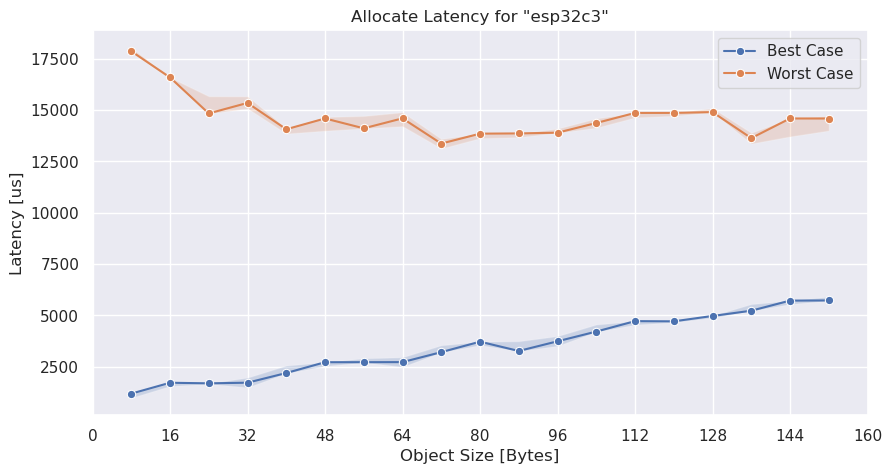

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme()

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

if len(allocate_min) != 0:
    sns.lineplot(ax=ax, data=allocate_min, x="object_size", y="mean", label="Best Case", markers=["o"], marker="o")
    ax.fill_between(allocate_min["object_size"], allocate_min["min"], allocate_min["max"], alpha=0.2)

if len(allocate_max) != 0:
    sns.lineplot(ax=ax, data=allocate_max, x="object_size", y="mean", label="Worst Case", markers=["o"], marker="o")
    ax.fill_between(allocate_max["object_size"], allocate_max["min"], allocate_max["max"], alpha=0.2)

max_x = max(allocate_min["object_size"].max(), allocate_max["object_size"].max())
max_x = (max_x / 16) * 16
if max_x % 16 != 0:
    max_x += 16

# set grid to be multiple of 16 (and 8)
major_ticks = np.arange(0, max_x, 16)
minor_ticks = np.arange(0, max_x, 8)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set_xlabel("Object Size [Bytes]")
ax.set_ylabel("Latency [us]")
ax.set_title("Allocate Latency for \"" + allocate_min["machine_name"][0] + "\"")